# Profit Optimization for Airbnb Hosts: A ML-Based Recommendation System 

## 1. Project Overview  
> **Goal** : Rather than just predicting price, the goal is to recommend actionable listing improvements (like adjusting room type, number of beds, or amenities) that would maximize revenue (estimated by price minus cleaning + deposit costs).


## 2. Data
The following dataset is a sample (assume random) of available Airbnb listings in Seattle, WA. These listings were collected in January 2016, and filtered to just contain listings from the four most popular Seattlbe neighborhoods for Airbnb listings and just contain listings that are either in a house or apartment property.

**Listing Information**: The dataset contains the following information about the Airbnb listing:

| Column Name             | Description                                      |
| ----------------------- | ------------------------------------------------ |
| `price`                 | price of the listing (per night)(in US dollars)  |
| `review_scores_rating`  | the average rating of the listing [0,100] (100 is the best)|
| `number_of_reviews`     | the number of reviews for the listing                      |
| `security_deposit`      | the security deposit required for the listing (in US dollars) |
| `cleaning_fee`          | the cleaning fee required for the listing (in US dollars)  |
| `neighborhood`          | the neighborhood of Seattle the listing is located in |
| `property_type`         | is the listing in a 'House' or 'Apartment' |
| `room_type`             | is the listing a 'Entire home/apt', 'Private room', or 'Shared room' |
| `accommodates`          | how many guests will the listing accommodate|
| `bathrooms`             | how many bathrooms does the listing have|
| `beds`                  | how many beds does the listing have|

**Host Information**: The dataset also contains the following information about the host of the given Airbnb listing:
| Column Name             | Description                                      |
| ----------------------- | ------------------------------------------------ |
| `host_is_superhost`     | is the host a "superhost": t=True, f=False  |
| `host_has_profile_pic`  | does the host have a profile pic in their bio: t=True, f=False|
| `host_response_time`    | how fast will the host respond to requests (on average)|

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [91]:
# Import dataset
df = pd.read_csv("data/seattle_airbnb_listings.csv")
df.head()

,price,review_scores_rating,number_of_reviews,security_deposit,cleaning_fee,neighborhood,property_type,room_type,accommodates,bathrooms,beds,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified
0,300,100,24,500,95,Wallingford,House,Entire home/apt,5,1.5,3,within a few hours,1.0,t,t,t
1,149,96,11,300,105,Wallingford,Apartment,Entire home/apt,6,1.0,3,within an hour,1.0,f,t,t
2,95,95,79,150,40,Wallingford,Apartment,Entire home/apt,3,1.0,2,within an hour,1.0,f,t,t
3,105,100,13,500,50,Wallingford,House,Private room,2,2.0,1,within a few hours,1.0,t,t,t
4,140,99,30,250,65,Wallingford,House,Entire home/apt,2,1.0,1,within an hour,1.0,t,t,t


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   292 non-null    int64  
 1   review_scores_rating    292 non-null    int64  
 2   number_of_reviews       292 non-null    int64  
 3   security_deposit        292 non-null    int64  
 4   cleaning_fee            292 non-null    int64  
 5   neighborhood            292 non-null    object 
 6   property_type           292 non-null    object 
 7   room_type               292 non-null    object 
 8   accommodates            292 non-null    int64  
 9   bathrooms               292 non-null    float64
 10  beds                    292 non-null    int64  
 11  host_response_time      292 non-null    object 
 12  host_response_rate      292 non-null    float64
 13  host_is_superhost       292 non-null    object 
 14  host_has_profile_pic    292 non-null    ob

In [93]:
df.isna().sum()

price                     0
review_scores_rating      0
number_of_reviews         0
security_deposit          0
cleaning_fee              0
neighborhood              0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
beds                      0
host_response_time        0
host_response_rate        0
host_is_superhost         0
host_has_profile_pic      0
host_identity_verified    0
dtype: int64

Yay! There's no null values which is good. So we are not going to be misrepresenting our population of airbnb listings and we can move on to our summary statistics.

In [94]:
neighborhood_counts = df['neighborhood'].value_counts()
neighborhood_counts

neighborhood
Broadway       120
Wallingford     66
Belltown        57
Minor           49
Name: count, dtype: int64

In [95]:
neighborhood_percentages = df['neighborhood'].value_counts(normalize=True)
neighborhood_percentages

neighborhood
Broadway       0.410959
Wallingford    0.226027
Belltown       0.195205
Minor          0.167808
Name: proportion, dtype: float64

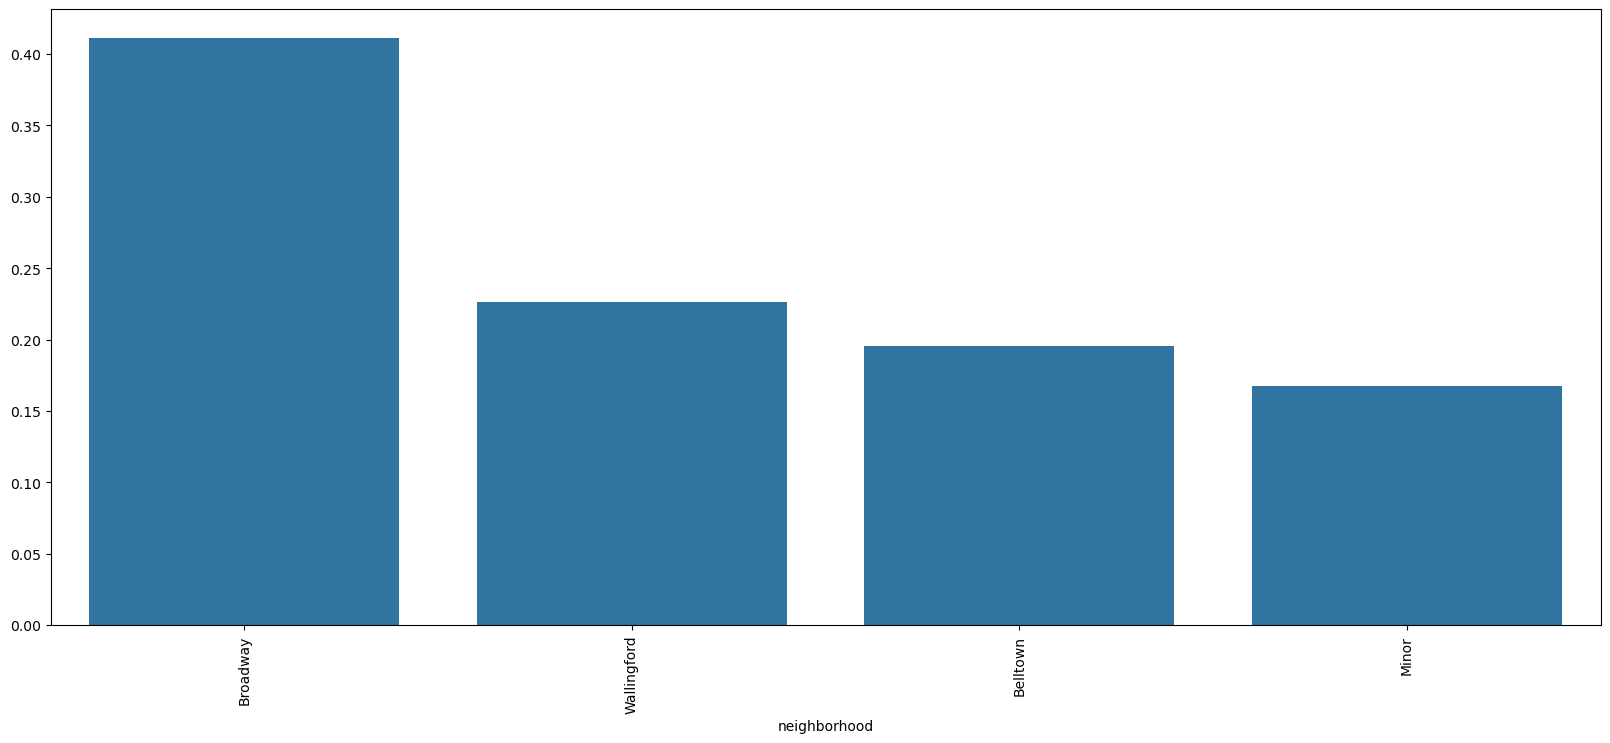

In [96]:
plt.figure(figsize=(20, 8))
sns.barplot(x=neighborhood_percentages.index, y=neighborhood_percentages.values)
plt.xticks(rotation=90)
plt.show()

In [97]:
df.describe()

,price,review_scores_rating,number_of_reviews,security_deposit,cleaning_fee,accommodates,bathrooms,beds,host_response_rate
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.00000
mean,128.904110,94.301370,28.554795,278.215753,58.003425,3.342466,1.188356,1.684932,0.95589
std,91.088932,7.587628,37.453298,266.657633,40.589259,2.042296,0.536119,1.095153,0.09846
min,35.000000,20.000000,1.000000,95.000000,5.000000,1.000000,0.500000,1.000000,0.25000
25%,79.000000,93.000000,5.000000,150.000000,35.000000,2.000000,1.000000,1.000000,0.97000
50%,114.500000,96.000000,14.000000,250.000000,50.000000,3.000000,1.000000,1.000000,1.00000
75%,149.250000,99.000000,37.250000,350.000000,75.000000,4.000000,1.000000,2.000000,1.00000
max,999.000000,100.000000,278.000000,2500.000000,300.000000,16.000000,3.500000,9.000000,1.00000


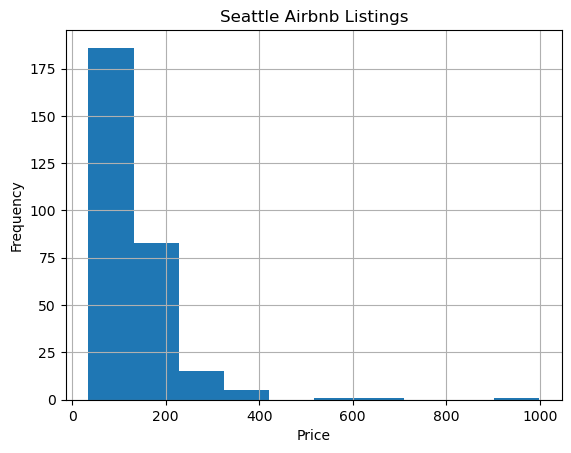

In [98]:
df['price'].hist()
plt.title('Seattle Airbnb Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

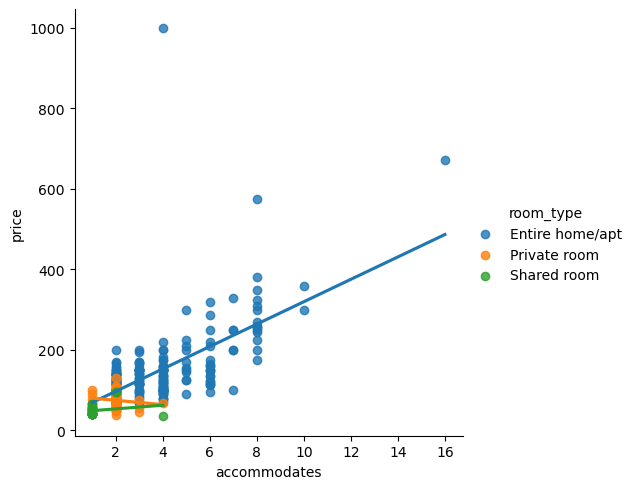

In [99]:
sns.lmplot(x='accommodates', y='price', hue='room_type', ci=False, data=df)
plt.show()

In [100]:
df[['room_type', 'accommodates', 'price']].groupby(['room_type']).corr()

accommodates     price
room_type                                           
Entire home/apt accommodates      1.000000  0.596754
                price             0.596754  1.000000
Private room    accommodates      1.000000 -0.139829
                price            -0.139829  1.000000
Shared room     accommodates      1.000000  0.185762
                price             0.185762  1.000000

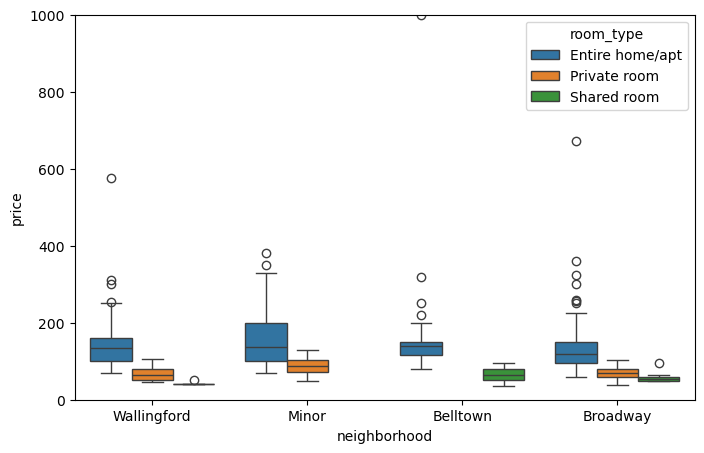

In [101]:
plt.figure(figsize=(8,5))
sns.boxplot(x='neighborhood', y='price', hue='room_type', data=df)
plt.ylim([0,1000])
plt.show()

In [102]:
bool_cols = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic']

for col in bool_cols:
    df[col] = df[col].map({'t': 1, 'f': 0})

In [103]:
df['profit'] = df['price'] - df['cleaning_fee'] - (df['security_deposit'] * 0.1)

In [104]:
# Convert from string percentage to float
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float) / 100
df['price_per_person'] = df['price'] / df['accommodates']

# One-hot encode categorical variables
df_profit = pd.get_dummies(df, columns=['room_type', 'property_type', 'neighborhood'], drop_first=True)

<Axes: xlabel='room_type', ylabel='profit'>

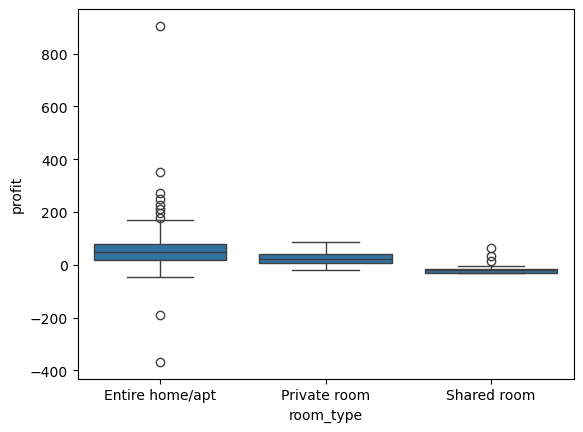

In [105]:
# If you still have access to original data:
room_type = df['room_type']
sns.boxplot(x=room_type, y=df['profit'])

From this, I'm making these inferences:

- Room type is a very predictive feature for profitability.
- Shared rooms may not be financially sustainable (on average).
- High outliers in “entire home” suggest there may be other boosting factors (e.g., location, superhost status, number of beds).

In [106]:
df.columns

Index(['price', 'review_scores_rating', 'number_of_reviews',
       'security_deposit', 'cleaning_fee', 'neighborhood', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'beds', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'profit', 'price_per_person'],
      dtype='object')

<Axes: >

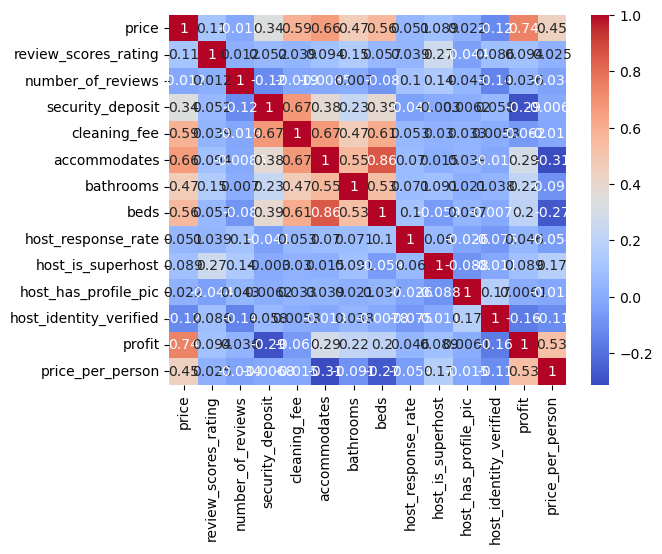

In [107]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")

<Axes: xlabel='profit', ylabel='Count'>

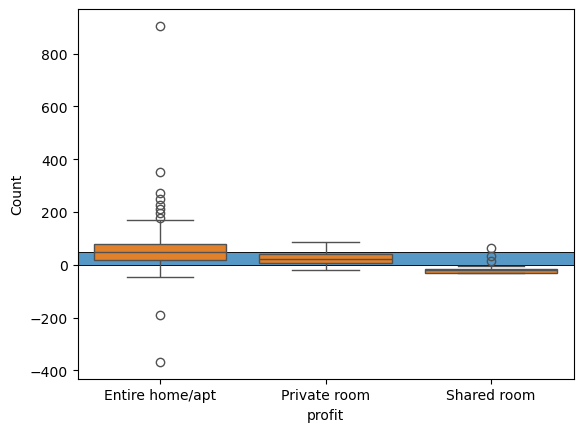

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['profit'], bins=50)
sns.boxplot(x='room_type', y='profit', data=df) 

In [111]:
non_numeric_cols = X.select_dtypes(include='object').columns
print(non_numeric_cols)
X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

Index(['neighborhood', 'property_type', 'room_type', 'host_response_time'], dtype='object')


RandomForestRegressor(random_state=42)

In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 11.62
RMSE: 18.77
R² Score: 0.86


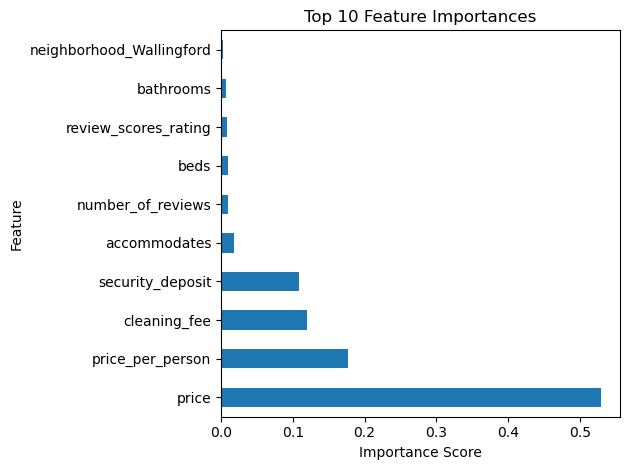

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

# Plot top 10
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

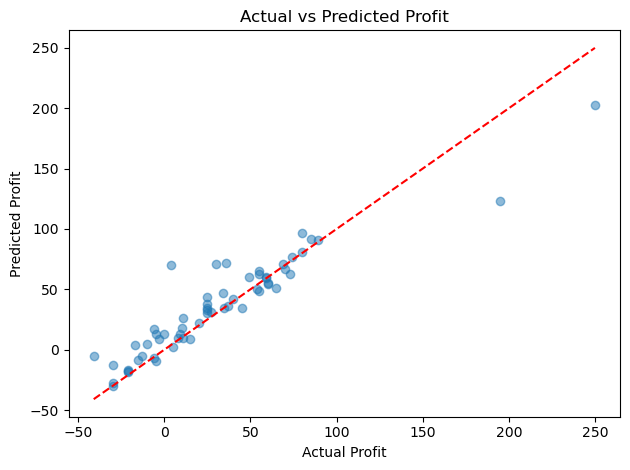

In [114]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Actual vs Predicted Profit")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

## 3. Counterfactual Analysis

In [115]:
# Grab an example row (could be low profit or a random listing)
listing = X_test.iloc[10].copy()
original_profit = model.predict([listing])[0]

/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [116]:
# Simulate changing from shared room to entire home
scenario_1 = listing.copy()
scenario_1['room_type_Private room'] = 0
scenario_1['room_type_Shared room'] = 0  # entire home implied by both being 0

# Simulate increasing number of beds
scenario_2 = listing.copy()
scenario_2['beds'] += 1

# Simulate being a superhost
scenario_3 = listing.copy()
scenario_3['host_is_superhost'] = 1

In [117]:
print("Original predicted profit:", round(original_profit, 2))
print("With Entire Home:", round(model.predict([scenario_1])[0], 2))
print("With +1 Bed:", round(model.predict([scenario_2])[0], 2))
print("With Superhost:", round(model.predict([scenario_3])[0], 2))

Original predicted profit: 77.13
With Entire Home: 77.13
With +1 Bed: 76.89
With Superhost: 77.13


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [118]:
scenarios = {
    "Original": listing,
    "Entire Home": scenario_1,
    "One More Bed": scenario_2,
    "Superhost": scenario_3
}

profits = {label: model.predict([data])[0] for label, data in scenarios.items()}

# Rank by predicted profit
sorted_profits = sorted(profits.items(), key=lambda x: x[1], reverse=True)

for label, profit in sorted_profits:
    print(f"{label}: ${profit:.2f}")

Original: $77.13
Entire Home: $77.13
Superhost: $77.13
One More Bed: $76.89


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [120]:
def recommend_profit_improvements(listing, model):
    scenarios = {
        "Original": listing.copy(),
        "Entire Home": listing.copy(),
        "One More Bed": listing.copy(),
        "Superhost": listing.copy()
    }

    # Apply scenario modifications
    scenarios["Entire Home"]['room_type_Private room'] = 0
    scenarios["Entire Home"]['room_type_Shared room'] = 0
    scenarios["One More Bed"]['beds'] += 1
    scenarios["Superhost"]['host_is_superhost'] = 1

    # Predict profits
    profits = {label: model.predict([data])[0] for label, data in scenarios.items()}
    sorted_profits = sorted(profits.items(), key=lambda x: x[1], reverse=True)

    print("💡 Profit Improvement Scenarios:")
    for label, profit in sorted_profits:
        print(f"{label}: ${profit:.2f}")

    best = sorted_profits[0]
    if best[0] != "Original":
        print(f"\n✅ Recommended: Change to '{best[0]}' — gain of ${best[1] - profits['Original']:.2f}")
    else:
        print("\n👍 The current listing is already optimal.")

In [121]:
recommend_profit_improvements(X_test.iloc[10].copy(), model)

💡 Profit Improvement Scenarios:
Original: $77.13
Entire Home: $77.13
Superhost: $77.13
One More Bed: $76.89

👍 The current listing is already optimal.


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


I also included a What-If Recommendation Engine that evaluates hypothetical listing improvements (e.g., becoming a superhost, increasing bed count) to suggest changes that maximize expected profit, based on the trained model’s predictions.

## 4. Conclusion